### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

# custom packages
from ratsimulator import trajectory_generator
from ratsimulator.Environment import Rectangle

import datetime
import sys
import os
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 

from PlaceCells import PlaceCells
from Models import SorscherRNN
from methods import *
import spatial_maps as sm # CINPLA spatial maps

### Set parameters and initialise

In [3]:
"""
# Sorscher params
options.save_dir = '/mnt/fs2/bsorsch/grid_cells/models/'
options.n_steps = 100000      # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment
"""
_ = 2

In [4]:
params = {}
# Environment params
params['boxsize'] = (2.2, 2.2)
params['origo'] = (0,0)
params['soft_boundary'] = 0.03 # Sorscher uses 0.03, I used to have 0.2
# Place Cells params
params['npcs'] = 512 # as used in Sorscher model
params['pc_width'] = 0.12
params['DoG'] = True
params['seed'] = 0 # place-cell center seed
# Training data (Agent) params
params['batch_size'] = 200
params['seq_len'] = 20
params['angle0'] = None # random
params['p0'] = None     # random
# Agent/random walk parameters
params['dt'] = 0.02
params['turn_angle'] = 5.76 * 2
params['b'] = 0.13 * 2 * np.pi
params['mu'] = 0
params['boundary_mode'] = 'sorschers' # 'sorschers' or 'zenos'
# Model params
params['Ng'] = 4096
params['Np'] = params['npcs'] # defined for Brain already
params['weight_decay'] = 1e-4
params['lr'] = 1e-4# 1e-3 is default for Adam()
params['nsteps'] = 100 # number of mini batches in an epoch
params['nepochs'] = 1000 # number of epochs
# metadata
params['tag'] = 'default'
params['save_freq'] = 5
params['date'] = datetime.datetime.now()

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

device=device(type='cuda')


In [5]:
# Init Environment
environment = Rectangle(boxsize=params['boxsize'], soft_boundary=params['soft_boundary'])
params['environment_name'] = type(environment).__name__

# Init brain
place_cells = PlaceCells(environment=environment, **params)

# Init training data
dataset_size = params['nsteps'] * params['nepochs']
dataset = Dataset(environment=environment, place_cells=place_cells, dataset_size = dataset_size, **params)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], num_workers=num_workers)

# Init model
model = SorscherRNN(Ng=params['Ng'], Np=params['Np']) 
model.to(device)
print(f"{model = }")

# Init optimizer (use custom weight decay, rather than torch optim decay)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], betas=(0.9, 0.999), \
                             eps=1e-08, weight_decay=0.0, amsgrad=False)

Singular matrix
Singular matrix
model = SorscherRNN(
  (init_position_encoder): Linear(in_features=512, out_features=4096, bias=False)
  (RNN): RNN(2, 4096, bias=False, batch_first=True)
  (decoder): Linear(in_features=4096, out_features=512, bias=False)
)


### Data pathing. To save/load model weights and results

In [6]:
# create model model tag
model_tag = type(model).__name__ + "_" + params["tag"]
print(f"{model_tag = }")

# create relevant paths
from pathlib import Path
data_path = Path().home() / "data"
project_path = data_path / "emergent-grid-cells"
model_path = project_path / model_tag
checkpoint_path = model_path / "checkpoints"
pickle_path = model_path / "pickle_objects"
print(f"{checkpoint_path = }")
print(f"{pickle_path = }")

model_tag = 'SorscherRNN_default'
checkpoint_path = PosixPath('/home/users/vemundss/data/emergent-grid-cells/SorscherRNN_default/checkpoints')
pickle_path = PosixPath('/home/users/vemundss/data/emergent-grid-cells/SorscherRNN_default/pickle_objects')


### Train/Load Model

In [7]:
loss_history = []
training_metrics = {}

if loaded_model:=True:
    # get latest (wrt. #epochs trained) model weights
    onlyfiles = [f for f in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path, f))]
    onlyfiles.sort()
    checkpoint_epoch = onlyfiles[-1]
    # overwrite and choose manually which weights to load
    #checkpoint_epoch = "0001"
    print(f"Loading model at epoch = {checkpoint_epoch}")
    
    # load model
    checkpoints = torch.load(checkpoint_path / checkpoint_epoch)
    model.load_state_dict(checkpoints['model_state_dict'])
    optimizer.load_state_dict(checkpoints['optimizer_state_dict'])
    loss_history = checkpoints['loss_history']
    training_metrics = checkpoints['training_metrics']
    print("Loaded weights")
    
# whether to train
if train:=False:
    loss_history = model.train(trainloader = dataloader, optimizer = optimizer, weight_decay=params['weight_decay'], \
                               nepochs=params['nepochs'], checkpoint_path = checkpoint_path, params = params, \
                               save_freq = params['save_freq'], loss_history = loss_history, training_metrics = training_metrics, )

Loading model at epoch = 1000
Loaded weights


## **Analyse Model**
### Training history

Maximum Entropy possible: 6.2383246250395095


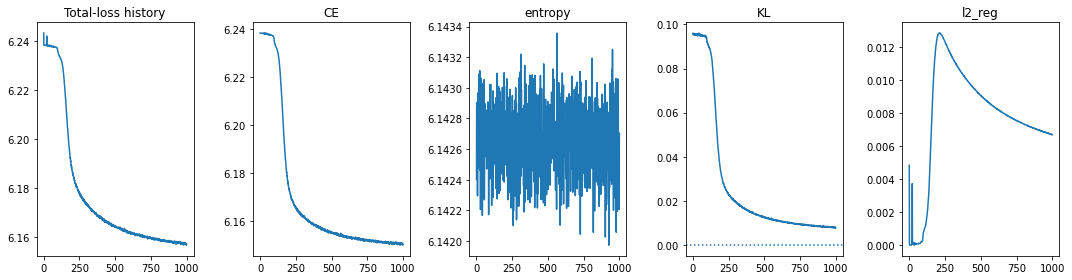

In [8]:
fig, ax = plt.subplots(ncols=5,figsize=(15,4))
ax[0].plot(loss_history)
ax[0].set_title('Total-loss history')

for i,(key,value) in enumerate(checkpoints['training_metrics'].items()):
    if key == 'KL':
        ax[i+1].axhline(0,ls=":")
    ax[i+1].plot(value)
    ax[i+1].set_title(key)
plt.tight_layout()

# maximum labelled distribution entropy (uniform labelled distribution)
n = 512
px = np.ones(n) / n # uniform
entropy = lambda x: -np.sum(x * np.log(x))
print(f"Maximum Entropy possible: {entropy(px)}")

### Create/Load ratemaps and grid score

In [9]:
ratemaps_path = pickle_path / (checkpoint_epoch + "_ratemaps.pkl")
if os.path.exists(ratemaps_path):
    with open(ratemaps_path, "rb") as f:
        ratemaps = pickle.load(f)
    print("Loaded ratemaps")
else:
    # create ratemaps
    idxs = slice(0, params['Ng'], 1)
    res = np.array([32, 32])
    print("Calculating ratemaps")
    ratemaps = compute_ratemaps(model=model.g, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
    with open(ratemaps_path, "wb") as f:
        pickle.dump(ratemaps,f)
    print("Saved ratemaps")

Loaded ratemaps


In [10]:
def score_ratemaps(ratemaps):
    # if grid scores have already been calculate and saved to disk, load these (FAST!)
    score_map_path = pickle_path / (checkpoint_epoch + "_grid_scores.pkl")
    if os.path.exists(score_map_path):
        print(os.path.split(score_map_path)[-1], "already exists. Loading score map.")
        with open(score_map_path, "rb") as f:
            score_map = pickle.load(f)
        return score_map
    
    # BANINO (and Sorscher) grid scoring method
    from scores import GridScorer
    res = np.array([32,32])
    starts = [0.2] * 10
    ends = np.linspace(0.4, 1.0, num=10)
    box_width, box_height = params['boxsize']
    coord_range=((params['origo'][0], box_width), (params['origo'][0], box_height))
    coords_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
    mask_parameters = zip(starts, ends.tolist())
    scorer = GridScorer(nbins=res[0], coords_range=coords_range, mask_parameters=mask_parameters)

    # score ratemaps
    score_map = np.zeros(params['Ng']) # ratemap score lookup table
    print("Calculating grid score for the ratemaps")
    for i in tqdm.trange(params['Ng']):
        # interpolated_ratemap = interpolate_missing_pixels(ratemaps[i], np.isnan(ratemaps[i]))
        # score_map[i] = sm.gridness(interpolated_ratemap)
        score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(ratemaps[i])
        score_map[i] = score_60
        
    # make dirs and pickle ratemaps
    if not os.path.exists(pickle_path):
        os.makedirs(pickle_path)
    with open(score_map_path, "wb") as f:
        pickle.dump(score_map,f)
    return score_map

score_map = score_ratemaps(ratemaps)

# sort scores and ratemaps
sort_idxs = np.argsort(score_map)
sorted_scores = score_map[sort_idxs][::-1]
sorted_ratemaps = ratemaps[sort_idxs][::-1]

1000_grid_scores.pkl already exists. Loading score map.


Text(0.5, 0.98, 'gc_score = 0.5052089189468025 -- 0.38591792211131354')

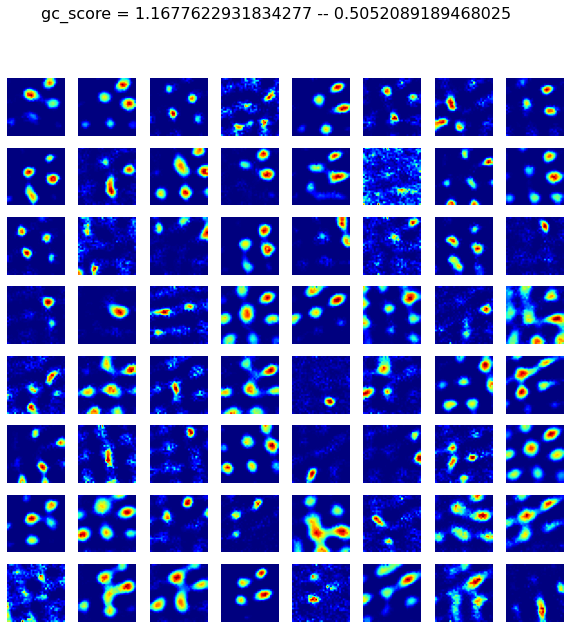

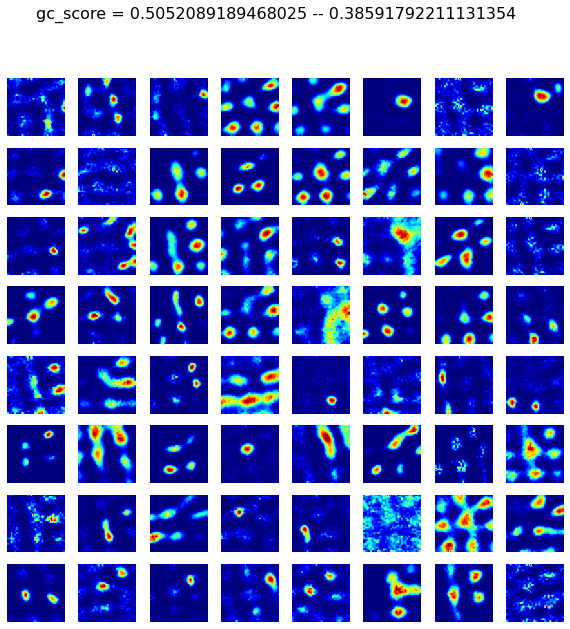

In [11]:
start_idx = 0
num_ratemaps = 64
fig, ax = multiimshow(sorted_ratemaps[start_idx:start_idx+num_ratemaps])
fig.suptitle(f"gc_score = {sorted_scores[start_idx]} -- {sorted_scores[start_idx+num_ratemaps]}", fontsize=16)
fig, ax = multiimshow(sorted_ratemaps[start_idx+num_ratemaps:start_idx+2*num_ratemaps])
fig.suptitle(f"gc_score = {sorted_scores[start_idx+num_ratemaps]} -- {sorted_scores[start_idx+2*num_ratemaps]}", fontsize=16)

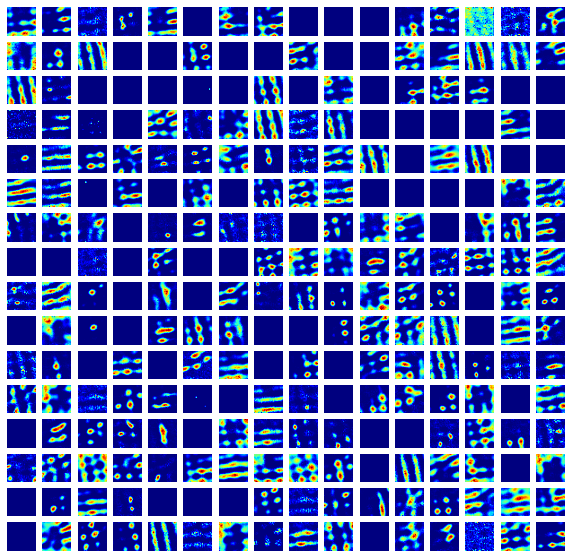

In [12]:
start_idx = 256*12
num_ratemaps = 256
fig, ax = multiimshow(ratemaps[start_idx:start_idx+num_ratemaps])

### Predicted place Cells (with(out) SOFTMAX)

In [13]:
"""
forward_with_softmax = lambda x: torch.exp(model(x, log_softmax=True))
ratemaps = compute_ratemaps(model=model, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
fig, ax = multiimshow(ratemaps)
"""

'\nforward_with_softmax = lambda x: torch.exp(model(x, log_softmax=True))\nratemaps = compute_ratemaps(model=model, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]\nfig, ax = multiimshow(ratemaps)\n'

In [14]:
model.prune_mask = list(range(int(4096/2),4096)) # set prune mask
model.prune_mask = [] # reset prune mask
model.prune_mask

[tensor([[1., 1.],
         [1., 1.],
         [1., 1.],
         ...,
         [1., 1.],
         [1., 1.],
         [1., 1.]], device='cuda:0'),
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')]

/home/users/vemundss/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/modules/rnn.py:268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635068699003/work/aten/src/ATen/native/cudnn/RNN.cpp:925.)
  result = _impl(input, hx, self._flat_weights, self.bias, self.num_layers,


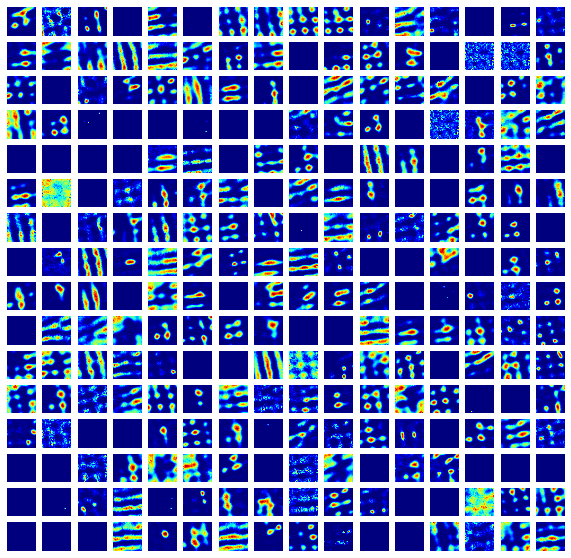

In [15]:
idxs=slice(0, 16**2, 1)
res=np.array([32, 32])
ratemaps = compute_ratemaps(model=model.g, dataset=dataset, num_trajectories=1250, res=res, idxs=idxs)[0]
fig, ax = multiimshow(ratemaps)

### Decoding labels and predictions to cartesian

In [16]:
[[vel, init_pos], labels] = dataset[0]
true_cartesian_pos = dataset.agent.positions
true_decoded_pos = place_cells.to_euclid(torch.cat([init_pos[None], labels]))
pc_preds = model([vel, init_pos]).detach().cpu()[0]
predicted_decoded_pos = place_cells.to_euclid(torch.cat([init_pos[None], pc_preds]))

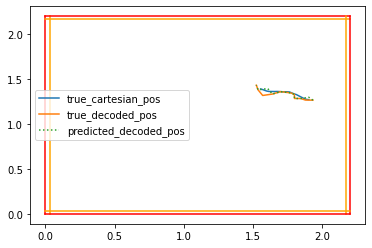

In [17]:
fig, ax = plt.subplots()
ax.plot(*true_cartesian_pos.T, label='true_cartesian_pos')
ax.plot(*true_decoded_pos.T, label='true_decoded_pos')
ax.plot(*predicted_decoded_pos.T, label='predicted_decoded_pos', ls=':')
environment.plot_board(ax)
ax.legend()

### Plot all place cell centers and some with tuning curves

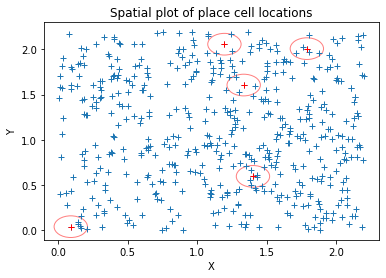

In [18]:
fig, ax = plt.subplots()
x,y = place_cells.pcs.T

ax.plot(x, y, "+")
# add standard deviation circles to locations
for i in range(5):
    ax.plot(x[i], y[i], "r+")
    a_circle = plt.Circle((x[i], y[i]), params['pc_width'], fill=False, color=(1, 0, 0, 0.5))
    ax.add_artist(a_circle)

plt.title("Spatial plot of place cell locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Calculate grid scores using different implementations of the metric

In [19]:
# Custom grid score
print("CUSTOM:", grid_score(ratemaps[1])) 

# CINPLA grid score
import spatial_maps as sm
print("CINPLA:", sm.gridness(ratemaps[1])) 

# BANINO (and Sorscher) grid scoring
from scores import GridScorer
"""
One difference from custom and CINPLA grid scores: 
1. Uses average difference between phase60 and phase30 correlations
"""
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
coord_range=((0, environment.boxsize[0]), (0, environment.boxsize[1]))
box_width, box_height = 2.2, 2.2
coords_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
mask_parameters = zip(starts, ends.tolist())
scorer = GridScorer(nbins=res[0], coords_range=coords_range, mask_parameters=mask_parameters)

#score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
#      *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_map_lores)])
score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(ratemaps[1])
print("BANINO/SORSCHER:", score_60)

CUSTOM: 0.013436398905151692
CINPLA: 0.35030879964712724
BANINO/SORSCHER: 0.5704614555243576


/home/users/vemundss/Prosjekter/emergent-grid-cells/notebooks/../src/scores.py:141: RuntimeWarning: invalid value encountered in true_divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


In [20]:
# choose grid scoring function to use, e.g: grid_score, sm.gridness or scorer.get_scores
# for scorer.get_scores use: < (lambda rm: scorer.get_scores(rm)[0])(rate_map) >
grid_scoring_fn = lambda rate_map: sm.gridness(rate_map)

#map(grid_scoring_fn, *ratemaps)
grid_scoring_fn(ratemaps[1])

0.35030879964712724

### Small analysis / checks / tests etc

np.min(W)=-0.12849165, np.max(W)=0.14164379, np.min(abs(W))=2e-44, np.mean(W)=-4.6165707e-05, np.std(W)=0.0019952438, np.sum(W**2)=66.82575


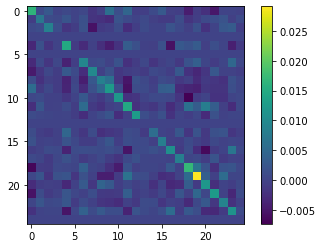

In [21]:
# Wr = model.recurrence.weight.detach().cpu().numpy()
Wr = model.RNN.weight_hh_l0.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wr)
plt.imshow(Wr[:25,:25])
plt.colorbar()

np.min(W)=-1.6305436, np.max(W)=1.769187, np.min(abs(W))=1.0739415e-07, np.mean(W)=-0.0095994985, np.std(W)=0.19625823, np.sum(W**2)=80969.87


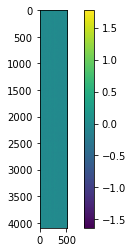

In [22]:
Wp = model.init_position_encoder.weight.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wp)
plt.imshow(Wp)
plt.colorbar()